<a href="https://colab.research.google.com/github/zavavan/case2023_task2/blob/main/Evaluation_Pipeline_Task_2_CASE2022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Setup

In [ ]:
#!python -m pip uninstall matplotlib
#!pip install matplotlib==3.1.3

In [ ]:
from IPython.display import clear_output
#!pip install argparse
!pip install xtract
!pip install wget
import time as time
import ipywidgets as widgets
import json
#clear_output()
import gzip
import shutil
import os
import wget
import csv
import linecache
from shutil import copyfile
import numpy as np
import pandas as pd
import datetime
import shapely.speedups

# To plot pretty figures
#%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

!pip install geopandas
!pip install scipy
!pip install shapely
!pip install bokeh
!pip install cartopy
!pip install statsmodels
!pip install sklearn
!pip install osmnx
!pip install folium

import numpy as np
import pandas as pd
import geopandas as gpd
import scipy
import shapely
#import matplotlib.pyplot as plt
import bokeh
import cartopy
import statsmodels
import sklearn
import osmnx
import folium
from sklearn.metrics import mean_squared_error

import time


In [3]:
from tqdm import tqdm

In [ ]:
import multiprocessing

cores = multiprocessing.cpu_count() # Count the number of cores in a computer
cores

In [ ]:
import time
from joblib import Parallel, delayed
from tqdm import tqdm
from functools import partial
import string
import traceback

In [ ]:
def chunkIt(seq, num):
    avg = len(seq) / float(num)
    out = []
    last = 0.0

    while last < len(seq):
        out.append(seq[int(last):int(last + avg)])
        last += avg

    return out

In [4]:
# Where to save the figures
PROJECT_ROOT_DIR = "/content/drive/MyDrive/Colab Notebooks/CASE2023_Task2"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")

def save_fig(fig_id, tight_layout=False, fig_extension="png", resolution=1200):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [5]:
INPUT_DATA_PATH = os.path.join(PROJECT_ROOT_DIR, "SYSTEM_SUBMISSIONS")
os.makedirs(INPUT_DATA_PATH, exist_ok=True)

def load_system_submission(input_data_path,system_name,submission_name,_header):
    path = os.path.join(input_data_path, system_name, submission_name)
    ext = os.path.splitext(path)[-1].lower()
    if ext == ".csv":
      print('loading system submission data from csv file: ' + path)
      return pd.read_csv(path,header=_header)
    elif ext == ".xlsx":
      print('loading system submission data from excel file: ' + path)
      return pd.read_excel(path, index_col=_header)

#"D:\\knime_workspace\\Event Deduplication Evaluation New\\Data\\CASE2021\\Hu-Tiancheng-ETH\\submission.NoConflict.twitter.1.csv"

## Open Street Map (Nominatim API) location normalization

The String representation of the event location will be automatically converted into a pair of geographical coordinates by using the Nominatim search API (https://nominatim.org/release-docs/develop/api/Search/). While only the country attribute is mandatory, systems are expected to assign a description of the event location at the finest grained level possible, as otherwise geographical coordinate conversion from Nominatim will place the event at the geographical centroid of the polygon of the assigned administrative unit, which may penalize the correlation score on Prio-GRID cell aggregation.
   

In [6]:
!pip install geopy
from geopy.geocoders import Nominatim

In [7]:
geolocator = Nominatim(user_agent="case2022_task2",timeout=30)

In [8]:
def make_structured_query(x, y, z):
    return {"city":x, "state":y, "country":z}

### System Output File

In [9]:
system_output = load_system_submission("/content/drive/MyDrive/Colab Notebooks/CASE2023_Task2/SYSTEM_SUBMISSIONS","mordecai","submission.mordecai.news.2.csv",0)

loading system submission data from csv file: /content/drive/MyDrive/Colab Notebooks/CASE2023_Task2/SYSTEM_SUBMISSIONS/mordecai/submission.mordecai.news.2.csv


In [ ]:
system_output.head()

### Column mapping for not compliant system output files ###

In [10]:
len(system_output)

519

In [11]:
system_output=system_output.dropna(subset=['name_0'])

In [ ]:
len(system_output)

262

In [12]:
system_output_expanded = pd.DataFrame(columns=['date','city', 'state', 'country','lat','lon'])

In [ ]:
system_output_expanded

In [13]:
for index, row in system_output.iterrows():
  mapped_row = {'date': row['date'], 'city': row['name_0'],'state':row['admin1_name_0'],'country': row['country_code3_0'],'lat':row['lat_0'],'lon': row['lon_0']}
  system_output_expanded.loc[len(system_output_expanded)] = mapped_row
  if not pd.isna(row['name_1']):
    mapped_row = {'date': row['date'], 'city': row['name_1'],'state':row['admin1_name_1'],'country': row['country_code3_1'],'lat':row['lat_1'],'lon': row['lon_1']}
    system_output_expanded.loc[len(system_output_expanded)] = mapped_row
  if not pd.isna(row['name_2']):
    mapped_row = {'date': row['date'], 'city': row['name_2'],'state':row['admin1_name_2'],'country': row['country_code3_2'],'lat':row['lat_2'],'lon': row['lon_2']}
    system_output_expanded.loc[len(system_output_expanded)] = mapped_row
  if not pd.isna(row['name_3']):
    mapped_row = {'date': row['date'], 'city': row['name_3'],'state':row['admin1_name_3'],'country': row['country_code3_3'],'lat':row['lat_3'],'lon': row['lon_3']}
    system_output_expanded.loc[len(system_output_expanded)] = mapped_row
  if not pd.isna(row['name_4']):
    mapped_row = {'date': row['date'], 'city': row['name_4'],'state':row['admin1_name_4'],'country': row['country_code3_4'],'lat':row['lat_4'],'lon': row['lon_4']}
    system_output_expanded.loc[len(system_output_expanded)] = mapped_row
  if not pd.isna(row['name_5']):
    mapped_row = {'date': row['date'], 'city': row['name_5'],'state':row['admin1_name_5'],'country': row['country_code3_5'],'lat':row['lat_5'],'lon': row['lon_5']}
    system_output_expanded.loc[len(system_output_expanded)] = mapped_row
  if not pd.isna(row['name_6']):
    mapped_row = {'date': row['date'], 'city': row['name_6'],'state':row['admin1_name_6'],'country': row['country_code3_6'],'lat':row['lat_6'],'lon': row['lon_6']}
    system_output_expanded.loc[len(system_output_expanded)] = mapped_row
  if not pd.isna(row['name_7']):
    mapped_row = {'date': row['date'], 'city': row['name_7'],'state':row['admin1_name_7'],'country': row['country_code3_7'],'lat':row['lat_7'],'lon': row['lon_7']}
    system_output_expanded.loc[len(system_output_expanded)] = mapped_row
  if not pd.isna(row['name_8']):
    mapped_row = {'date': row['date'], 'city': row['name_8'],'state':row['admin1_name_8'],'country': row['country_code3_8'],'lat':row['lat_8'],'lon': row['lon_8']}
    system_output_expanded.loc[len(system_output_expanded)] = mapped_row


In [14]:
system_output_expanded['id'] = system_output_expanded.index

In [15]:
system_output_expanded

,date,city,state,country,lat,lon,id
0,2023-04-02 09:55:24+00:00,Bakhmut,Donetsk,UKR,48.59441,37.99983,0
1,2023-03-10 04:01:26+00:00,Avdiivka,Donetsk,UKR,48.13989,37.74255,1
2,2023-03-09 20:25:46+00:00,Bakhmut,Donetsk,UKR,48.59441,37.99983,2
3,2023-03-08 06:23:44+00:00,Vesele,Donetsk,UKR,47.93379,36.76199,3
4,2023-03-02 01:03:39+00:00,Nuevo Laredo,Tamaulipas,MEX,27.47629,-99.51639,4
...,...,...,...,...,...,...,...
363,2022-04-27 21:37:01+00:00,Sievierodonetsk,Luhansk,UKR,48.94628,38.48624,363
364,2022-04-27 21:37:01+00:00,Luhanska Oblast,Luhansk,UKR,49.00000,39.00000,364
365,2022-03-14 18:22:05+00:00,Mariupol,Donetsk,UKR,47.09514,37.54131,365
366,2022-03-14 18:22:05+00:00,Mariupol,Donetsk,UKR,47.09514,37.54131,366




---



In [ ]:
system_output = system_output[['id','city','country','lat','lon' ]]

In [ ]:
system_output



---



In [ ]:
system_output.columns =['id','city', 'state', 'country', 'date']
system_output.tail()

In [ ]:
#so_locations = system_output[['city','state','country']].value_counts(ascending=False).reset_index(name='count')[['city','state','country']]

In [ ]:
so_locations = system_output[['city','country']].value_counts(ascending=False).reset_index(name='count')[['city','country']]

In [ ]:
so_locations

,city,country
0,Kherson Oblast,UKR
1,Bakhmut,UKR
2,Ukraine,UKR
3,Kharkiv,UKR
4,Sievierodonetsk,UKR
...,...,...
142,Logvinovo,RUS
143,Liman,AZE
144,La Bandera,MEX
145,Kyiv,UKR


In [ ]:
#so_results = [geolocator.geocode(make_structured_query(x,y,z)) if geolocator.geocode(make_structured_query(x,y,z)) is not None else geolocator.geocode(x + "," + y + "," + z)  for x, y, z in so_locations[['city','state','country']].to_numpy()]


In [ ]:
so_results = [geolocator.geocode(make_structured_query(x,'',z)) if geolocator.geocode(make_structured_query(x,'',z)) is not None else geolocator.geocode(x + "," + '' + "," + z)  for x, z in so_locations[['city','country']].to_numpy()]


In [ ]:
so_locations['lat'] = [result.latitude if result is not None else 'NaN' for result in so_results]
so_locations['lon'] = [result.longitude if result is not None else 'NaN' for result in so_results]

In [ ]:
so_locations

,city,country,lat,lon
0,Kherson Oblast,UKR,NaN,NaN
1,Bakhmut,UKR,NaN,NaN
2,Ukraine,UKR,49.386572,30.18246
3,Kharkiv,UKR,48.88914,36.312881
4,Sievierodonetsk,UKR,48.943717,38.506217
...,...,...,...,...
142,Logvinovo,RUS,NaN,NaN
143,Liman,AZE,NaN,NaN
144,La Bandera,MEX,19.585386,-98.700994
145,Kyiv,UKR,49.386572,30.18246


In [ ]:
so_locations.to_csv("/content/drive/MyDrive/Colab Notebooks/CASE2023_Task2/SYSTEM_SUBMISSIONS/mordecai/OSMNormalizedLocations.submission.mordecai.news.1.csv",index=False)

In [ ]:
#system_output['lat'] = [ so_locations.loc[(so_locations['city'] == x) & (so_locations['state'] == y) & (so_locations['country'] == z), 'lat'].iloc[0]  for x,y,z in system_output[['city','state','country']].to_numpy()]
#system_output['lon'] = [ so_locations.loc[(so_locations['city'] == x) & (so_locations['state'] == y) & (so_locations['country'] == z), 'lon'].iloc[0]  for x,y,z in system_output[['city','state','country']].to_numpy()]

In [ ]:
system_output['lat'] = [ so_locations.loc[(so_locations['city'] == x) &  (so_locations['country'] == z), 'lat'].iloc[0]  for x,z in system_output[['city','country']].to_numpy()]
system_output['lon'] = [ so_locations.loc[(so_locations['city'] == x) &  (so_locations['country'] == z), 'lon'].iloc[0]  for x,z in system_output[['city','country']].to_numpy()]

<ipython-input-50-7f322890b6a3>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  system_output['lat'] = [ so_locations.loc[(so_locations['city'] == x) &  (so_locations['country'] == z), 'lat'].iloc[0]  for x,z in system_output[['city','country']].to_numpy()]
<ipython-input-50-7f322890b6a3>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  system_output['lon'] = [ so_locations.loc[(so_locations['city'] == x) &  (so_locations['country'] == z), 'lon'].iloc[0]  for x,z in system_output[['city','country']].to_num

In [16]:
system_output_expanded.to_csv("/content/drive/MyDrive/Colab Notebooks/CASE2023_Task2/SYSTEM_SUBMISSIONS/mordecai/submission.mordecai.news.2.OSMNormalized.csv",index=False)

In [17]:
len(system_output_expanded)

368

### Gold Standard File

In [18]:
gs = load_system_submission("/content/drive/MyDrive/Colab Notebooks/CASE2023_Task2","GOLD_STANDARD","ACLED22.4-22.08.22.xlsx",0)
#df.columns =['id','city', 'state', 'country', 'date','url']


loading system submission data from excel file: /content/drive/MyDrive/Colab Notebooks/CASE2023_Task2/GOLD_STANDARD/ACLED22.4-22.08.22.xlsx


In [19]:
len(gs)

18261

In [ ]:
gs.tail()

In [20]:
locations_gs = gs[['LOCATION','ADMIN1','COUNTRY']].value_counts(ascending=False).reset_index(name='count')[['LOCATION','ADMIN1','COUNTRY']]

In [21]:
len(locations_gs)

1681

In [ ]:
# Iterating over two columns, use `zip`
#results_gs = [geolocator.geocode(make_structured_query(x,y,z)) if geolocator.geocode(make_structured_query(x,y,z)) is not None else geolocator.geocode(x + "," + y + "," + z) for x, y, z in locations_gs[['LOCATION','ADMIN1','COUNTRY']].to_numpy()]


In [ ]:
#results_gs

In [ ]:
#locations_gs['lat'] = [result.latitude if result is not None else 'NaN' for result in results_gs]
#locations_gs['lon'] = [result.longitude if result is not None else 'NaN' for result in results_gs]

In [ ]:
#len(locations_gs)

In [ ]:
#locations_gs.head()

In [ ]:
locations_gs.to_csv("/content/drive/MyDrive/Colab Notebooks/CASE2023_Task2/GOLD_STANDARD/OSMNormalizedLocations.csv",index=False)

In [23]:
locations_gs = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/CASE2023_Task2/GOLD_STANDARD/OSMNormalizedLocations.csv",header=0)

In [24]:
gs['lat'] = [ locations_gs.loc[(locations_gs['LOCATION'] == x) & (locations_gs['ADMIN1'] == y) & (locations_gs['COUNTRY'] == z)].iloc[0]['lat'] if len(locations_gs.loc[(locations_gs['LOCATION'] == x) & (locations_gs['ADMIN1'] == y) & (locations_gs['COUNTRY'] == z)])!=0 else float('nan') for x,y,z in gs[['LOCATION','ADMIN1','COUNTRY']].to_numpy() ]
gs['lon'] = [ locations_gs.loc[(locations_gs['LOCATION'] == x) & (locations_gs['ADMIN1'] == y) & (locations_gs['COUNTRY'] == z)].iloc[0]['lon'] if len(locations_gs.loc[(locations_gs['LOCATION'] == x) & (locations_gs['ADMIN1'] == y) & (locations_gs['COUNTRY'] == z)])!=0 else float('nan') for x,y,z in gs[['LOCATION','ADMIN1','COUNTRY']].to_numpy()]

In [ ]:
gs.head(3)

In [26]:
gs['EVENT_ID_NO_CNTY']=gs.index

In [ ]:
gs.columns

In [28]:
gs.to_csv("/content/drive/MyDrive/Colab Notebooks/CASE2023_Task2/GOLD_STANDARD/russo-ukrainian_conflict.OSMNormalized.csv",index=False)

## PRIO-GRID normalization

We join event point shapefiles with a PRIO-GRID shapefile. PRIO-GRID is a vector grid network with a resolution of 0.5 x 0.5 decimal degrees (~55 km), covering all terrestrial areas of the world.
The following code is the equivalent of the following QGIS procedure:
Menu > Vector > Data Management Tools > Join attributes by location
Target : points layer, Join layer: polygons layer. That way info from your districts goes into your points Geometric predicate : Check ON all the options: intersects, touches etc. I haven't looked further into this yet but just one option had not worked out earlier.
Attributes summary : Take attributes of first located feature Joined table :
Keep all records ... that will preserve the points that were outside of all the wards too

### Loading the PRIOGrid shape file

In [29]:
tic = time.time()
fp = "/content/drive/MyDrive/Colab Notebooks/CASE2022_Task2/priogrid_shapefiles/priogrid_cell.shp"

# Read the data
priogrid = gpd.read_file(fp)
priogrid.set_crs("EPSG:4326")
toc = time.time()
print('time to read the priogrid shape file = ' + str((toc - tic)/60) + ' minutes' )

selected_cols = ['gid', 'geometry']
priogrid = priogrid[selected_cols]

time to read the priogrid shape file = 1.1022597233454385 minutes


In [30]:
priogrid.head()


,gid,geometry
0,259168,"POLYGON ((163.50000 89.50000, 163.50000 90.000..."
1,259169,"POLYGON ((164.00000 89.50000, 164.00000 90.000..."
2,259170,"POLYGON ((164.50000 89.50000, 164.50000 90.000..."
3,259171,"POLYGON ((165.00000 89.50000, 165.00000 90.000..."
4,259172,"POLYGON ((165.50000 89.50000, 165.50000 90.000..."


In [31]:
[priogrid.loc[priogrid['gid'] == 181609]['geometry']]

[77566    POLYGON ((-96.00000 36.00000, -96.00000 36.500...
 Name: geometry, dtype: geometry]

### Loading the US country shape file ###



In [ ]:
tic = time.time()
fp = "/content/drive/MyDrive/Colab Notebooks/CASE2022_Task2/gadm36_USA_shp/gadm36_USA_0.shp"
usa = gpd.read_file(fp)
toc = time.time()
print('time to read the US shape file = ' + str((toc - tic)/60) + ' minutes' )

usa.info()

time to read the US shape file = 0.02243025302886963 minutes
<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   GID_0     1 non-null      object  
 1   NAME_0    1 non-null      object  
 2   geometry  1 non-null      geometry
dtypes: geometry(1), object(2)
memory usage: 152.0+ bytes


### Loading the Ukraine and Russia country shape files ###

In [ ]:
tic = time.time()
fp = "/content/drive/MyDrive/Colab Notebooks/CASE2023_Task2/gis/gadm36_UKR_0.shp"
ukr = gpd.read_file(fp)
toc = time.time()
print('time to read the Ukraine shape file = ' + str((toc - tic)/60) + ' minutes' )

ukr.info()

In [33]:
type(ukr.loc[0, 'geometry'])
type(priogrid['geometry'])

geopandas.geoseries.GeoSeries

In [ ]:
tic = time.time()
fp = "/content/drive/MyDrive/Colab Notebooks/CASE2023_Task2/gis/gadm36_RUS_0.shp"
rus = gpd.read_file(fp)
toc = time.time()
print('time to read the RUS shape file = ' + str((toc - tic)/60) + ' minutes' )

rus.info()

### Intersection of PRIOGrid with the US country shape file

In [ ]:
shapely.speedups.enable()
# enable shapely.speedups which makes queries running faster.

tic = time.time()
priogrid_mask = pd.Series()

priogrid_mask = priogrid['geometry'].intersects(usa.loc[0, 'geometry'])
priogrid_mask.to_frame().to_csv("/content/drive/MyDrive/Colab Notebooks/CASE2022_Task2/priogrid_shapefiles/priogrid_mask.csv",index=False)
# selecting the polygon's geometry field to filter out points that are not overlaid
toc = time.time()
print('time to execute the intersection with USA shape file = ' + str((toc - tic)/60) + ' minutes' )




### Intersection of PRIOGrid with the UKR-RUS merged country shape files

In [ ]:
shapely.speedups.enable()

In [38]:
s = gpd.GeoSeries([ukr.loc[0, 'geometry'], rus.loc[0, 'geometry']])
print(s)
union = s.unary_union
print(type(union))

0    MULTIPOLYGON (((36.55069 45.26153, 36.55069 45...
1    MULTIPOLYGON (((131.36847 42.69708, 131.36847 ...
dtype: geometry
<class 'shapely.geometry.multipolygon.MultiPolygon'>


In [39]:
# enable shapely.speedups which makes queries running faster.

tic = time.time()
priogrid_mask = pd.Series()

#priogrid_mask = priogrid['geometry'].intersects(union.loc[0, 'geometry'])
priogrid_mask = priogrid['geometry'].intersects(union)

priogrid_mask.to_frame().to_csv("/content/drive/MyDrive/Colab Notebooks/CASE2023_Task2/gis/priogrid_mask.csv",index=False)
# selecting the polygon's geometry field to filter out points that are not overlaid
toc = time.time()
print('time to execute the intersection with UKR-RUS shape file = ' + str((toc - tic)/60) + ' minutes' )

time to execute the intersection with UKR-RUS shape file = 15.955746579170228 minutes


In [40]:
priogrid_ukr_rus = priogrid.loc[priogrid_mask]

In [41]:
priogrid_ukr_rus.to_csv("/content/drive/MyDrive/Colab Notebooks/CASE2023_Task2/gis/priogrid_ukr-rus.csv",index=False)


### Gold Standard File
###### reading the OSM-normalized Gold Standard from file:

In [42]:
gsOSMNormalized = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/CASE2023_Task2/GOLD_STANDARD/russo-ukrainian_conflict.OSMNormalized.csv",header=0)

gsOSMNormalized=gsOSMNormalized.dropna(subset=['lon'])
gsOSMNormalized=gsOSMNormalized.dropna(subset=['lat'])


gs_gdf = gpd.GeoDataFrame(
    gsOSMNormalized, geometry=gpd.points_from_xy(gsOSMNormalized.lon, gsOSMNormalized.lat))
gs_gdf = gs_gdf.set_crs("EPSG:4326")


In [43]:
print(len(gsOSMNormalized))
len(gs_gdf)

16415


16415

In [ ]:
gs_gdf.head()

###### joining it with UKR-RUS subset of PRIOGrid cells:

In [ ]:
tic = time.time()

# Make a spatial join
join = gs_gdf.sjoin(priogrid_ukr_rus, how="inner", op="within")
toc = time.time()
print('time to execute the sjoin with PRIOGrid shape file = ' + str((toc - tic)/60) + 'minutes' )

In [46]:
join.columns

Index(['EVENT_DATE', 'YEAR', 'TIME_PRECISION', 'DISORDER_TYPE', 'EVENT_TYPE',
       'SUB_EVENT_TYPE', 'ACTOR1', 'ASSOC_ACTOR_1', 'INTER1', 'ACTOR2',
       'ASSOC_ACTOR_2', 'INTER2', 'INTERACTION', 'CIVILIAN_TARGETING', 'ISO',
       'REGION', 'COUNTRY', 'ADMIN1', 'ADMIN2', 'ADMIN3', 'LOCATION',
       'LATITUDE', 'LONGITUDE', 'GEO_PRECISION', 'SOURCE', 'SOURCE_SCALE',
       'NOTES', 'FATALITIES', 'TAGS', 'TIMESTAMP', 'lat', 'lon',
       'EVENT_ID_NO_CNTY', 'geometry', 'index_right', 'gid'],
      dtype='object')

In [47]:
selected_cols1 = ['EVENT_ID_NO_CNTY','LOCATION','ADMIN1','COUNTRY','EVENT_DATE','lat','lon','geometry','gid']
join = join[selected_cols1]

In [48]:
dict = {'EVENT_ID_NO_CNTY': 'id',
        'LOCATION': 'city',
        'ADMIN1': 'state',
        'COUNTRY': 'country',
        'EVENT_DATE': 'date' }

# call rename () method
join.rename(columns=dict,inplace=True)
join.to_csv("/content/drive/MyDrive/Colab Notebooks/CASE2023_Task2/GOLD_STANDARD/russo-ukrainian_conflict.OSMNormalized.PrioAggregated.csv",index=False)

### Intersection with the US country shape file

In [ ]:
gsPrioAggregated = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/CASE2023_Task2/GOLD_STANDARD/russo-ukrainian_conflict.OSMNormalized.PrioAggregated.csv",header=0)
gsPrioAggregated_gdf = gpd.GeoDataFrame(
    gsPrioAggregated, geometry=gpd.points_from_xy(gsPrioAggregated.lon, gsPrioAggregated.lat))
gsPrioAggregated_gdf = gsPrioAggregated_gdf.set_crs("EPSG:4326")

In [ ]:
import shapely.speedups

shapely.speedups.enable()
# enable shapely.speedups which makes queries running faster.

tic = time.time()
gs_union_mask = gsPrioAggregated_gdf['geometry'].within(union)
# selecting the polygon's geometry field to filter out points that are not overlaid
toc = time.time()
print('time to execute the intersection with USA shape file = ' + str((toc - tic)/60) + ' minutes' )

gs_ukr_rus_PrioAggregated = gsPrioAggregated.loc[gs_union_mask]
gs_union_mask.to_frame().to_csv("/content/drive/MyDrive/Colab Notebooks/CASE2023_Task2/GOLD_STANDARD/priogrid_mask.csv",index=False)
gs_ukr_rus_PrioAggregated.to_csv("/content/drive/MyDrive/Colab Notebooks/CASE2023_Task2/GOLD_STANDARD/covid_protests_riots_ukr_rus.OSMNormalized.PrioAggregated.csv",index=False)


<ipython-input-285-110370e612b8>:3: DeprecationWarning: This function has no longer any effect, and will be removed in a future release. Starting with Shapely 2.0, equivalent speedups are always available
  shapely.speedups.enable()


### System Output File

In [53]:
system_output = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/CASE2023_Task2/SYSTEM_SUBMISSIONS/mordecai/submission.mordecai.news.2.OSMNormalized.csv",header=0)


In [54]:
len(system_output)

368

In [55]:
system_output=system_output.dropna(subset=['lon'])
system_output=system_output.dropna(subset=['lat'])

In [56]:
len(system_output)

368

In [57]:
system_output_gdf = gpd.GeoDataFrame(
    system_output, geometry=gpd.points_from_xy(system_output.lon, system_output.lat))
system_output_gdf = system_output_gdf.set_crs("EPSG:4326")

In [ ]:
# Make a spatial join
tic = time.time()
join1 = system_output_gdf.sjoin(priogrid_ukr_rus, how="inner", op="within")
toc = time.time()
print('time to execute the sjoin with PRIOGrid shape file = ' + str((toc - tic)/60) + ' minutes' )
join1.head(5)

In [59]:
join1.columns

Index(['date', 'city', 'state', 'country', 'lat', 'lon', 'id', 'geometry',
       'index_right', 'gid'],
      dtype='object')

In [60]:
selected_cols1 = ['date', 'city', 'state', 'country', 'lat', 'lon', 'id', 'geometry','gid']
join1 = join1[selected_cols1]

In [61]:
print(len(join1))
join1.to_csv("/content/drive/MyDrive/Colab Notebooks/CASE2023_Task2/SYSTEM_SUBMISSIONS/mordecai/submission.mordecai.news.2.OSMNormalized_PRIO_Aggregated.csv",index=False)

252


In [ ]:
shapely.speedups.enable()
# enable shapely.speedups which makes queries running faster.

tic = time.time()
#gs_mask1 = join1['geometry'].within(union)
# selecting the polygon's geometry field to filter out points that
# are not overlaid
toc = time.time()
print('time to execute the intersection with USA shape file = ' + str((toc - tic)/60) + ' minutes' )

system_output = join1.loc[gs_mask1]


### VISUALIZING GOLD STANDARD AND SYSTEM OUTPUT EVENTS ON MAPS

In [ ]:
gs_ukr_rus_PrioAggregated = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/CASE2023_Task2/GOLD_STANDARD/russo-ukrainian_conflict.OSMNormalized.PrioAggregated.csv",header=0)
gsPrioAggregated_gdf = gpd.GeoDataFrame(
    gs_ukr_rus_PrioAggregated, geometry=gpd.points_from_xy(gs_ukr_rus_PrioAggregated.lon, gs_ukr_rus_PrioAggregated.lat))
gsPrioAggregated_gdf = gsPrioAggregated_gdf.set_crs("EPSG:4326")

gsPrioAggregated_gdf.head()


system_output_PrioAggregated = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/CASE2023_Task2/SYSTEM_SUBMISSIONS/mordecai/submission.mordecai.news.2.OSMNormalized_PRIO_Aggregated.csv",header=0)
system_output_PrioAggregated_gdf = gpd.GeoDataFrame(
    system_output_PrioAggregated, geometry=gpd.points_from_xy(system_output_PrioAggregated.lon, system_output_PrioAggregated.lat))
system_output_PrioAggregated_gdf = system_output_PrioAggregated_gdf.set_crs("EPSG:4326")

system_output_PrioAggregated_gdf.head()

In [65]:
#fig, ax = plt.subplots(figsize=(100,80))
map = folium.Map(location = [49.000,31.000], tiles='OpenStreetMap' , zoom_start = 4)

# mark each SO event as a red point
#for index, row in system_output.iterrows():
#        folium.CircleMarker([row['lat'], row['lon']], radius=2,popup=row['id'],fill_color='green').add_to(map)


def style_function(feature):
    return {'fillColor': '#00000000', 'color': 'black', "weight": 0.2 }

#priogrid_usa_geo_j = folium.GeoJson(data=priogrid_usa, style_function=style_function)
#folium.GeoJson(priogrid_usa_geo_j).add_to(map)

for index, r in priogrid_ukr_rus.iterrows():
    geo = gpd.GeoSeries(r['geometry'])
    geo_j = geo.to_json()
    geo_j = folium.GeoJson(data=geo_j,style_function=style_function)
    geo_j.add_to(map)

# mark each GS event as a blue point
for index, row in gsPrioAggregated_gdf.iterrows():
   folium.CircleMarker([row['lat'], row['lon']],radius=2,popup=row['id'],fill=True, color='blue').add_to(map)

# mark each GS event as a blue point
for index, row in system_output_PrioAggregated_gdf.iterrows():
   folium.CircleMarker([row['lat'], row['lon']],radius=2,popup=row['id'],fill=True, color='red').add_to(map)

map
#map.save(os.path.join(IMAGES_PATH, "MapVisualizationGS_and_SOs.htm"))

In [67]:
map

In [68]:
map.save(os.path.join(IMAGES_PATH, "MapVisualizationGS_and_BaselineSOs.htm"))

### Column filtering

In [72]:
system_output_PrioAggregated.columns

Index(['date', 'city', 'state', 'country', 'lat', 'lon', 'id', 'geometry',
       'gid'],
      dtype='object')

In [108]:
system_output_PrioAggregated = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/CASE2023_Task2/SYSTEM_SUBMISSIONS/mordecai/submission.mordecai.news.2.OSMNormalized_PRIO_Aggregated.csv",header=0)
system_output_PrioAggregated = system_output_PrioAggregated[['id', 'city', 'state', 'country','date', 'lat','lon','gid']]

In [71]:
gs_ukr_rus_PrioAggregated.columns

Index(['id', 'city', 'state', 'country', 'date', 'lat', 'lon', 'geometry',
       'gid'],
      dtype='object')

In [109]:
gs_ukr_rus_PrioAggregated = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/CASE2023_Task2/GOLD_STANDARD/russo-ukrainian_conflict.OSMNormalized.PrioAggregated.csv",header=0)
#gs_us_PrioAggregated.columns
gs_ukr_rus_PrioAggregated = gs_ukr_rus_PrioAggregated[['id', 'city', 'state', 'country','date','lat','lon','gid']]

### Date column type conversion and filtering by date

In [110]:
gs_ukr_rus_PrioAggregated['date'] = pd.to_datetime(gs_ukr_rus_PrioAggregated['date'], errors='raise')

In [111]:
gs_ukr_rus_PrioAggregated['date'] = gs_ukr_rus_PrioAggregated['date'].dt.normalize()

In [112]:
gs_ukr_rus_PrioAggregated = gs_ukr_rus_PrioAggregated[(gs_ukr_rus_PrioAggregated['date'] >= '24-2-2022') & (gs_ukr_rus_PrioAggregated['date'] <= '24-08-2022')]

<ipython-input-112-58fab8123738>:1: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  gs_ukr_rus_PrioAggregated = gs_ukr_rus_PrioAggregated[(gs_ukr_rus_PrioAggregated['date'] >= '24-2-2022') & (gs_ukr_rus_PrioAggregated['date'] <= '24-08-2022')]


In [ ]:
len(gs_ukr_rus_PrioAggregated)

In [128]:
system_output_PrioAggregated['date'] = pd.to_datetime(system_output_PrioAggregated['date'], errors='raise')
system_output_PrioAggregated['date'] = system_output_PrioAggregated['date'].dt.date

In [134]:
system_output_PrioAggregated['date'] = pd.to_datetime(system_output_PrioAggregated['date'], errors='raise')

In [ ]:
system_output_PrioAggregated

In [115]:
system_output_PrioAggregated = system_output_PrioAggregated[(system_output_PrioAggregated['date'] >= '24-2-2022') & (system_output_PrioAggregated['date'] <= '24-08-2022')]

<ipython-input-115-8e905fe89f58>:1: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  system_output_PrioAggregated = system_output_PrioAggregated[(system_output_PrioAggregated['date'] >= '24-2-2022') & (system_output_PrioAggregated['date'] <= '24-08-2022')]


In [130]:
len(system_output_PrioAggregated)

134

In [ ]:
#group_by_gid = gs_events_usa.groupby('gid').size().reset_index(name='count').sort_values(['count'], ascending=False)
#group_by_gid

In [ ]:
#events_usa_group_by_gid = events_usa.groupby('gid').size().reset_index(name='count').sort_values(['count'], ascending=False)

### Time shift (2 days) for news data

In [ ]:
system_output['date'] = [ x + datetime.timedelta(days=2) for x in system_output['date']  ]


### Sorting by date




In [131]:
gs_ukr_rus_PrioAggregated.sort_values(by="date")
system_output_PrioAggregated.sort_values(by="date")

,id,city,state,country,date,lat,lon,gid
248,361,Sumy,Sumy,UKR,2022-02-24,50.92160,34.80029,202750
251,360,Shchastia,Luhansk,UKR,2022-02-25,48.73784,39.23047,199879
178,113,Mariupol,Donetsk,UKR,2022-02-26,47.09514,37.54131,197716
90,359,Kharkiv,Kharkiv,UKR,2022-02-28,49.98081,36.25272,201313
249,357,Borodianka,Kiev,UKR,2022-03-01,50.64484,29.92010,202740
...,...,...,...,...,...,...,...,...
136,255,Zaporizhzhya Oblast,Zaporizhzhia,UKR,2022-08-12,47.83972,35.14057,198431
135,254,Zaporizhzhya,Zaporizhzhia,UKR,2022-08-12,47.85167,35.11714,198431
140,53,Mykolaiv,Lviv,UKR,2022-08-20,49.52659,23.98138,201288
232,250,Starytsia,Kharkiv,UKR,2022-08-21,50.24047,36.79312,202034


### Computing Location Ratio ###

In [118]:
gs_location_size = gs_ukr_rus_PrioAggregated.groupby(gs_ukr_rus_PrioAggregated['gid']).count()
ratio = len(gs_location_size)/len(gs_ukr_rus_PrioAggregated)
print(len(gs_location_size))
print(len(gs_ukr_rus_PrioAggregated))
print(ratio)

216
16415
0.013158696314346635


In [119]:
so_location_size = system_output_PrioAggregated.groupby(system_output_PrioAggregated['gid']).count()
ratio1 = len(so_location_size)/len(system_output_PrioAggregated)
print(len(so_location_size))
print(len(system_output_PrioAggregated))
print(ratio1)

51
134
0.3805970149253731


In [120]:
join_gid_diff_in_count = pd.merge(gs_ukr_rus_PrioAggregated.groupby(gs_ukr_rus_PrioAggregated['gid']).size().reset_index(name='gid_counts'), system_output_PrioAggregated.groupby(system_output_PrioAggregated['gid']).size().reset_index(name='gid_counts'), on='gid', how='outer').fillna(0)
join_gid_diff_in_count.head()

,gid,gid_counts_x,gid_counts_y
0,194108,5.0,0.0
1,194109,5.0,0.0
2,194830,1.0,0.0
3,194831,1.0,0.0
4,194833,1.0,0.0


In [121]:
join_gid_diff_in_count['countDiff'] = join_gid_diff_in_count.apply(lambda row: abs(row.gid_counts_x - row.gid_counts_y), axis=1)
#join_gid_diff_in_count.sort_values(by=['countDiff'], ascending=False)
#join_gid_diff_in_count=join_gid_diff_in_count['gid','countDiff']
join_gid_diff_in_count.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 225 entries, 0 to 224
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   gid           225 non-null    int64  
 1   gid_counts_x  225 non-null    float64
 2   gid_counts_y  225 non-null    float64
 3   countDiff     225 non-null    float64
dtypes: float64(3), int64(1)
memory usage: 8.8 KB


In [122]:
join_gid_diff_in_count = join_gid_diff_in_count.sort_values(by=['countDiff'], ascending=False)
join_gid_diff_in_count.head()

,gid,gid_counts_x,gid_counts_y,countDiff
93,199877,1772.0,19.0,1753.0
76,199156,1571.0,7.0,1564.0
160,202033,773.0,2.0,771.0
77,199157,764.0,0.0,764.0
92,199876,468.0,7.0,461.0


In [123]:
join_gid_with_prio_grid = pd.merge(join_gid_diff_in_count, priogrid, on='gid', how='left')
join_gid_with_prio_grid.head(20)


,gid,gid_counts_x,gid_counts_y,countDiff,geometry
0,199877,1772.0,19.0,1753.0,"POLYGON ((38.00000 48.50000, 38.00000 49.00000..."
1,199156,1571.0,7.0,1564.0,"POLYGON ((37.50000 48.00000, 37.50000 48.50000..."
2,202033,773.0,2.0,771.0,"POLYGON ((36.00000 50.00000, 36.00000 50.50000..."
3,199157,764.0,0.0,764.0,"POLYGON ((38.00000 48.00000, 38.00000 48.50000..."
4,199876,468.0,7.0,461.0,"POLYGON ((37.50000 48.50000, 37.50000 49.00000..."
5,200595,446.0,0.0,446.0,"POLYGON ((37.00000 49.00000, 37.00000 49.50000..."
6,199878,446.0,2.0,444.0,"POLYGON ((38.50000 48.50000, 38.50000 49.00000..."
7,198436,444.0,1.0,443.0,"POLYGON ((37.50000 47.50000, 37.50000 48.00000..."
8,199875,436.0,0.0,436.0,"POLYGON ((37.00000 48.50000, 37.00000 49.00000..."
9,198435,401.0,0.0,401.0,"POLYGON ((37.00000 47.50000, 37.00000 48.00000..."


### METRICS 1: Timeseries of daily "protest cells"

In [ ]:
time_series_gs_events = pd.DataFrame(columns=['Day','AttackCells'])

time_series_gs_events.Day = [  group[0] for group in gs_ukr_rus_PrioAggregated.groupby(gs_ukr_rus_PrioAggregated['date']) ]
time_series_gs_events.AttackCells = [   group[1]['gid'].nunique() for group in gs_ukr_rus_PrioAggregated.groupby(gs_ukr_rus_PrioAggregated['date']) ]

time_series_gs_events.head(10)

In [137]:
time_series_so_events = pd.DataFrame(columns=['Day','AttackCells'])

time_series_so_events.Day = [  group[0] for group in system_output_PrioAggregated.groupby(system_output_PrioAggregated['date']) ]
time_series_so_events.AttackCells = [   group[1]['gid'].nunique() for group in system_output_PrioAggregated.groupby(system_output_PrioAggregated['date']) ]

time_series_so_events.head(10)


,Day,AttackCells
0,2022-02-24,1
1,2022-02-25,1
2,2022-02-26,1
3,2022-02-28,1
4,2022-03-01,2
5,2022-03-03,1
6,2022-03-11,2
7,2022-03-12,1
8,2022-03-14,2
9,2022-03-19,1


In [138]:
joined_data_frame1 = (pd.merge(time_series_gs_events, time_series_so_events, on='Day', how='outer')
        .fillna(0)
        .sort_values('Day')
        .set_index('Day'))

In [105]:
joined_data_frame1.head()

,AttackCells_x,AttackCells_y
Day,,
2022-02-24 00:00:00+00:00,40,1.0
2022-02-25 00:00:00+00:00,40,1.0
2022-02-26 00:00:00+00:00,44,1.0
2022-02-27 00:00:00+00:00,30,0.0
2022-02-28 00:00:00+00:00,36,1.0


In [139]:
joined_data_frame1.rename(columns={"AttackCells_x":"GoldStandard","AttackCells_y":"mordecai_news_2"}, inplace=True)

In [ ]:
joined_data_frame1.head()

In [141]:
joined_data_frame1.to_csv("/content/drive/MyDrive/Colab Notebooks/CASE2023_Task2/results/metrics1.mordecai.news.2.csv",index=True)

In [143]:
joined_data_frame1.columns

Index(['GoldStandard', 'mordecai_news_2'], dtype='object')

In [ ]:
table = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/CASE2023_Task2/results/metrics1.mordecai.news.2.csv",header=0)


# to set the plot size
plt.figure(figsize=(13, 8), dpi=300)

# gca stands for 'get current axis'
ax = plt.gca()
table.plot(kind='line',x='Day',y='GoldStandard',color='orange',ax=ax)
table.plot(kind='line',x='Day',y='mordecai_news_2', color='green', ax=ax)
for label in ax.get_xticklabels(which='major'):
  label.set(rotation=30, horizontalalignment='right')

# adding title
#plt.title('News')

# adding label to x-axis
#plt.xlabel('Day')

# adding label to y-axis
plt.ylabel('Protest Cells')

# adding legend.
plt.legend()

#plt.save(os.path.join(IMAGES_PATH, "MapVisualizationGS_and_SOs.htm"))

plt.savefig(os.path.join(IMAGES_PATH, "AttackCellsTimeSeries_news.png"), format='png', dpi=300)

plt.show()

### Scores

In [144]:
joined_data_frame1.GoldStandard.corr(joined_data_frame1.mordecai_news_2, method="pearson")

0.027544499621465154

In [145]:
joined_data_frame1.GoldStandard.corr(joined_data_frame1.mordecai_news_2, method="spearman")

0.0012961648200781142

In [146]:
mean_squared_error(joined_data_frame1.GoldStandard, joined_data_frame1.mordecai_news_2, squared=True)

1407.9945054945056

## METRICS 2: Event count correlation on "day_cells":

## Iterate on days: join with PrioGrid_UKR-RUS

In [ ]:
#priogrid_usa = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/CASE2022_Task2/priogrid_shapefiles/priogrid_usa.csv",header=0)


In [ ]:
time_series_gs_events = pd.DataFrame()

for group in gs_ukr_rus_PrioAggregated.groupby(gs_ukr_rus_PrioAggregated['date']):
   outer_join = pd.merge(group[1].groupby('gid').size().reset_index(name='countID'), priogrid_ukr_rus['gid'],how="outer",on="gid").fillna(0)
   outer_join.insert(0, 'Day', group[0])
   time_series_gs_events = time_series_gs_events.append(outer_join)



In [ ]:
time_series_so_events = pd.DataFrame()

for group in system_output_PrioAggregated.groupby(system_output['date']):
   outer_join1 = pd.merge(group[1].groupby('gid').size().reset_index(name='countID'), priogrid_ukr_rus['gid'],how="outer",on="gid").fillna(0)
   outer_join1.insert(0, 'Day', group[0])
   time_series_so_events = time_series_so_events.append(outer_join1)



### Combining columns to create day_cell units:

In [149]:
time_series_gs_events['DayCell'] = time_series_gs_events['Day'].astype(str) +"_"+ time_series_gs_events["gid"].astype(str)


In [150]:
time_series_so_events['DayCell'] = time_series_so_events['Day'].astype(str) +"_"+ time_series_so_events["gid"].astype(str)


In [151]:
time_series_so_events['Day'] = pd.to_datetime(time_series_so_events['Day'], errors='raise')

In [ ]:
time_series_gs_events.info()

In [153]:
joined_data_frame2 = (pd.merge(time_series_gs_events, time_series_so_events, on='DayCell', how='outer')
        .fillna(0))

In [154]:
joined_data_frame2.columns

Index(['Day_x', 'gid_x', 'countID_x', 'DayCell', 'Day_y', 'gid_y',
       'countID_y'],
      dtype='object')

In [155]:
joined_data_frame2.rename(columns={"Day_x":"Day","countID_x":"GoldStandardEvents","countID_y":"SystemOutEvents"}, inplace=True)

In [ ]:
joined_data_frame2 = joined_data_frame2[['Day','DayCell','GoldStandardEvents','SystemOutEvents']]
joined_data_frame2.info()

In [157]:
joined_data_frame2.to_csv("/content/drive/MyDrive/Colab Notebooks/CASE2023_Task2/results/metrics2.mordecai.news.2.join.csv",index=False)

In [158]:
joined_data_frame2.columns

Index(['Day', 'DayCell', 'GoldStandardEvents', 'SystemOutEvents'], dtype='object')

In [159]:
joined_data_frame2.GoldStandardEvents.corr(joined_data_frame2.SystemOutEvents, method="pearson")

-0.00014906707622746508

In [160]:
joined_data_frame2.GoldStandardEvents.corr(joined_data_frame2.SystemOutEvents, method="spearman")

-0.00023903704255703303

In [161]:
mean_squared_error(joined_data_frame2.GoldStandardEvents, joined_data_frame2.SystemOutEvents, squared=True)

0.022276955737862317

In [162]:
joined_data_frame2.head()

,Day,DayCell,GoldStandardEvents,SystemOutEvents
0,2022-02-24 00:00:00,2022-02-24_196262,2.0,0.0
1,2022-02-24 00:00:00,2022-02-24_196268,1.0,0.0
2,2022-02-24 00:00:00,2022-02-24_196270,2.0,0.0
3,2022-02-24 00:00:00,2022-02-24_196986,3.0,0.0
4,2022-02-24 00:00:00,2022-02-24_196987,4.0,0.0


In [163]:
joined_data_frame2['GoldStandard'] = ['conflict' if x > 0 else 'no-conflict' for x in joined_data_frame2['GoldStandardEvents']]
joined_data_frame2['SystemOut'] = ['conflict' if x > 0 else 'no-conflict' for x in joined_data_frame2['SystemOutEvents']]

SystemOut     conflict  no-conflict
GoldStandard                       
conflict             0         6795
no-conflict        118      3742567


<Axes: xlabel='SystemOut', ylabel='GoldStandard'>

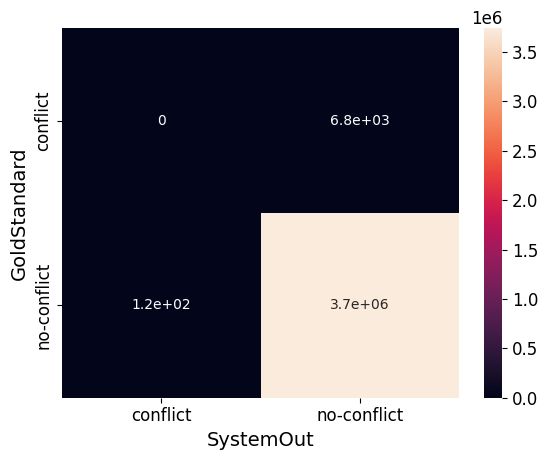

In [164]:
confusion_matrix = pd.crosstab(joined_data_frame2['GoldStandard'], joined_data_frame2['SystemOut'], rownames=['GoldStandard'], colnames=['SystemOut'])
print(confusion_matrix)
import seaborn as sn
sn.heatmap(confusion_matrix, annot=True)

In [165]:
joined_data_frame2.head()

,Day,DayCell,GoldStandardEvents,SystemOutEvents,GoldStandard,SystemOut
0,2022-02-24 00:00:00,2022-02-24_196262,2.0,0.0,conflict,no-conflict
1,2022-02-24 00:00:00,2022-02-24_196268,1.0,0.0,conflict,no-conflict
2,2022-02-24 00:00:00,2022-02-24_196270,2.0,0.0,conflict,no-conflict
3,2022-02-24 00:00:00,2022-02-24_196986,3.0,0.0,conflict,no-conflict
4,2022-02-24 00:00:00,2022-02-24_196987,4.0,0.0,conflict,no-conflict


In [166]:
from sklearn.metrics import precision_recall_fscore_support

y_true = joined_data_frame2.GoldStandard
y_pred = joined_data_frame2.SystemOut

print(precision_recall_fscore_support(y_true, y_pred))


(array([0.        , 0.99818769]), array([0.        , 0.99996847]), array([0.        , 0.99907729]), array([   6795, 3742685]))




---



### Cross-correlation functions ###

In [ ]:
# Function to calculate correlation
def correlation(x, y):
    shortest = min(x.shape[0], y.shape[0])
    return np.corrcoef(x.iloc[:shortest].values, y.iloc[:shortest].values)[0, 1]

In [ ]:
# Function to plot time series and show the correlation
def plot_correlation(x, y, text):
    # plot
    plt.subplots(figsize=(10, 6))
    x.plot(label="x")
    y.plot(label="y")
    plt.title(f"Correlation {text}: {correlation(x, y)}")
    plt.legend(loc="best")
    plt.show()

In [ ]:
from scipy.signal import correlate
from scipy.signal import correlation_lags

# Function to calculate cross-correlation,
# extract the best matching shift and then shift
# one of the series appropriately.
def shift_for_maximum_correlation(x, y):
    correlation = correlate(x, y, mode="full")
    print(correlation)
    lags = correlation_lags(x.size, y.size, mode="full")
    print(lags)
    lag = lags[np.argmax(correlation)]
    print(f"Best lag: {lag}")
    if lag < 0:
        y = y.iloc[abs(lag):].reset_index(drop=True)
    else:
        x = x.iloc[lag:].reset_index(drop=True)
    return x, y

In [ ]:
# Generate two series that are correlated
original_x = pd.Series(np.random.uniform(size=100))
original_y = 1.3*original_x + np.random.normal(0, 0.1, size=100)

#### Text example ###

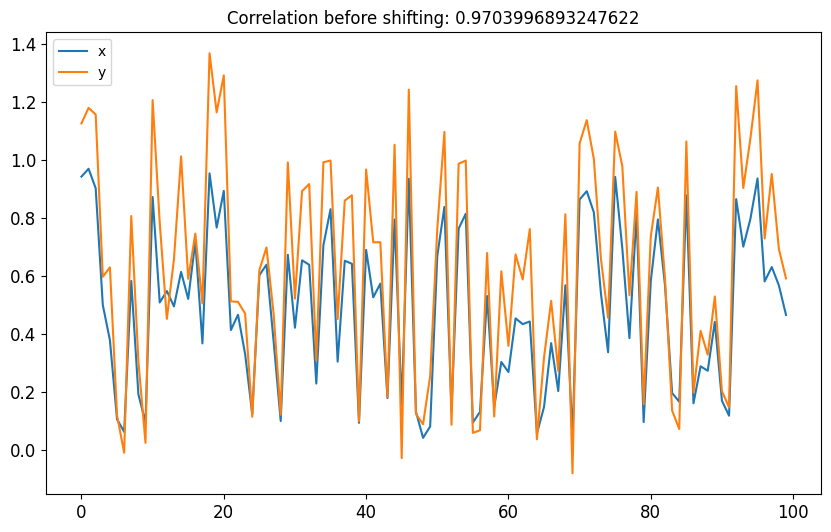

In [ ]:
# Show results without shifting
plot_correlation(original_x, original_y, "before shifting")

In [ ]:
# Now create shifted versions,
# I create two examples, one where x is shifted
# and one where y is.
shifted_versions = [
    (original_x.iloc[10:].reset_index(drop=True), original_y),
    (original_x, original_y.iloc[20:].reset_index(drop=True)),
]

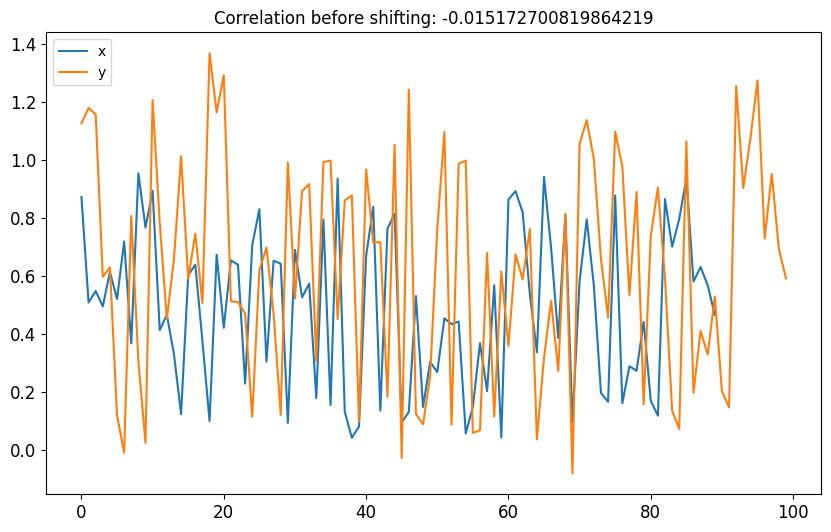

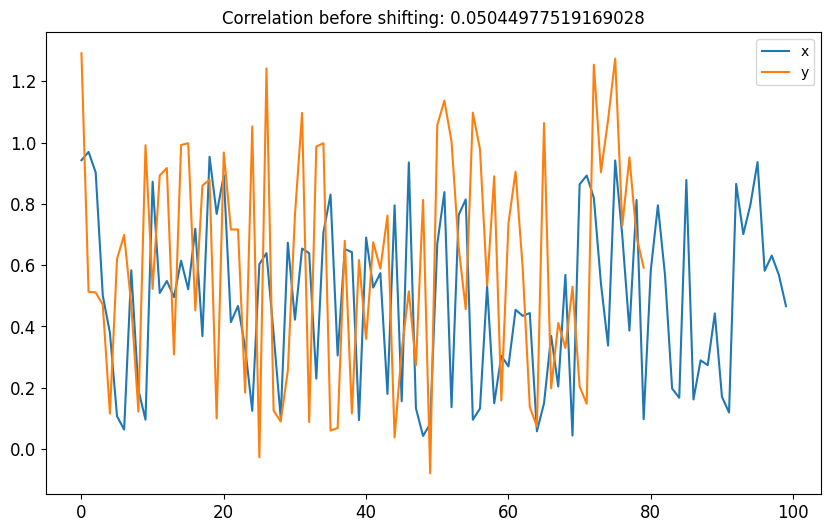

In [ ]:
# Show results without shifting
for x, y in shifted_versions:
    plot_correlation(x, y, "before shifting")

In [ ]:
for x, y in shifted_versions:
    shifted_x, shifted_y = shift_for_maximum_correlation(x, y)

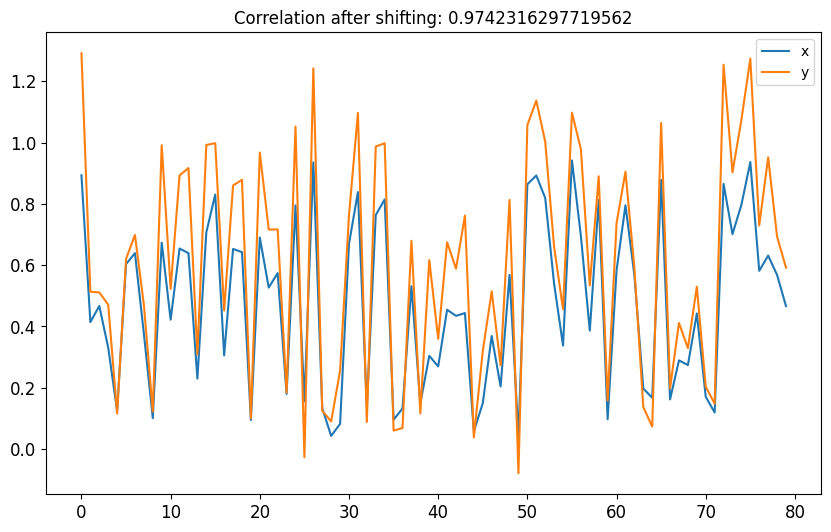

In [ ]:
plot_correlation(shifted_x, shifted_y, text="after shifting")



---

